# Index VISION DOCS helper

In [2]:
%reload_ext autoreload
%autoreload 2

# INDEX DOCS VISION

In [20]:
#%%writefile "../index_docs_vision.py"
import sys, os, io, torch, logging,datetime, hashlib, json, base64
from PIL import Image
import pdfplumber 
import numpy as np
from pdfplumber.page import Page

from gpt.gpt_utils import *

BASE = os.path.expanduser("~/data/gpt/")
#------------------------------------------INITIALIZE LLM Stuff -------------------- 
MYDB = myjson(base=BASE, db='INDICES')
INDEX_TABLE = "indexes"
#------------------------------------------------------------------------------------------ 


# Test

In [4]:
for e in "http_proxy https_proxy HTTP_PROXY HTTPS_PROXY".split():
    if e in os.environ: del os.environ[e]

from colpali_engine.models import ColQwen2, ColQwen2Processor

model_name = "vidore/colqwen2-v0.1"
modelp= os.path.expanduser(f"~/.cache/{model_name}/")

if os.path.exists(modelp):
    model_name = modelp
    pass
                  
model = ColQwen2.from_pretrained( model_name, torch_dtype=torch.bfloat16, device_map=device )
processor = ColQwen2Processor.from_pretrained(model_name)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


In [38]:
import pickle
def process_and_index_image1(image, img_str, image_hash, processor, model):
    batch_images = processor.process_images([image]).to(model.device)
    with torch.no_grad():
        image_embeddings = model(**batch_images)
    image_embedding = image_embeddings[0].cpu().to(torch.float32).numpy()
    # Serialize the embedding
    embedding_bytes = pickle.dumps(image_embedding)

    return image_embedding, embedding_bytes
    
file = "/Users/e346104/Desktop/data/images/table.png"
#image_data = uploaded_file.read()
image_data = open(file, "rb").read()

image = Image.open(io.BytesIO(image_data)).convert('RGB')
# Encode image to base64
buffered = io.BytesIO()
image.save(buffered, format="PNG")
img_str = base64.b64encode(buffered.getvalue()).decode()
im, eb = process_and_index_image1(image, img_str, None, processor, model)

In [40]:
im.shape, #eb.shape

((737, 128),)

In [35]:
#batch_images = processor.process_images([image]).to(model.device)
#batch_images

In [5]:
def _embed(imageOrQuery):
    if (type(imageOrQuery) == str):
        batch_data = processor.process_queries([imageOrQuery]).to(model.device)
    else:
        batch_data = processor.process_images([imageOrQuery]).to(model.device)

    with torch.no_grad():
        embeddings = model(**batch_data)
    embedding = embeddings[0].cpu().to(torch.float32).numpy()
    return embedding


def embed(file):
    buffer = io.BytesIO()
    if ( file.endswith(".pdf")):
        with pdfplumber.open(file) as doc:
            for page in doc.pages:
                image = page.to_image(resolution=200)
                image.save(buffer, format="PNG")
                image = Image.open(buffer)
                e =_embed(image)
                img_str = base64.b64encode(buffer.getvalue()).decode()
                addDB(file, e, image, img_str)
    else:
        image_data = open(file, "rb").read()

        image = Image.open(io.BytesIO(image_data)).convert('RGB')
        image.save(buffer, format="PNG")
        e =_embed(image)
        img_str = base64.b64encode(buffer.getvalue()).decode()
        addDB(file, e, image, img_str)

    return e, img_str

DB = {}
def addDB(file, embedding, image, img_str):
    entry = locals()
    global DB
    h = hashlib.md5(img_str.encode())
    DB[str(h.hexdigest()) ] = dict(entry)

def createDB():
    file = "/Users/e346104/Desktop/data/LLM/sample.pdf"
    embed(file)
    file = "/Users/e346104/Desktop/data/images/parking.jpg"
    embed(file)

createDB()

In [6]:
MAX_EMBEDDING_SEQ = 0
for k,v in DB.items():
    print(k, v['file'],  v['embedding'].shape)
    MAX_EMBEDDING_SEQ = max(MAX_EMBEDDING_SEQ, v['embedding'].shape[0])

95386af8c2777cfb9055f4e377c45480 /Users/e346104/Desktop/data/LLM/sample.pdf (755, 128)
947da4a6f7b72cbb4ed2140fe2cc945f /Users/e346104/Desktop/data/LLM/sample.pdf (755, 128)
a38ac302ea940567dc716faab9bb46a2 /Users/e346104/Desktop/data/images/parking.jpg (779, 128)


In [ ]:
qe = _embed(query)
qe.shape

(26, 128)

In [ ]:
import sqlite3, pickle
base = '/Users/e346104/git/DS/colpali-llama-vision-rag/'
conn = sqlite3.connect(f'{base}image_embeddings.db')
# Retrieve image embeddings from database
c = conn.cursor()
c.execute('SELECT image_base64, embedding FROM embeddings')
rows = c.fetchall()
conn.close()

assert rows, ("No images found in the index. Please add images first.")

image_embeddings_list = []
image_base64_list = []

DB1 = {}
for row in rows:
    image_base64, embedding_bytes = row
    embedding = pickle.loads(embedding_bytes)
    seq_len, embedding_dim = embedding.shape

    addDB("file", embedding, "image", image_base64,DB=DB1)


In [ ]:
def adjustSeq(to_len, embedding):
    seq_len, edim = embedding.shape

    if seq_len < to_len:
        padding = np.zeros((to_len - seq_len, edim), dtype=embedding.dtype)
        embedding_fixed = np.concatenate([embedding, padding], axis=0)
    elif seq_len > to_len:
        embedding_fixed = embedding[:to_len, :]
    else:
        embedding_fixed = embedding  
        
    return embedding_fixed

MAX_SEQ_LEN = min(620, MAX_EMBEDDING_SEQ)
#MAX_SEQ_LEN = min(qe.shape[0], MAX_EMBEDDING_SEQ)

query='''In a world where instant communication and the use of satellites in mobile
communication, television broadcasting, meteorology, earth observation and countless
other fields are almost taken for granted, the story of Ariane is worth telling. From its
beginning in 1973 up to the first decades of the 21st century, Ariane is continuously
suited to the market.'''

with torch.no_grad():
    image_embeddings_list = []
    image_base64_list = []

    for k,v in DB.items():
        image_base64, embedding = v['img_str'], v['embedding']
        embedding_fixed = adjustSeq(MAX_SEQ_LEN, embedding)
        image_embeddings_list.append(embedding_fixed)
        image_base64_list.append(image_base64)

    # Stack embeddings
    retrieved_image_embeddings = np.stack(image_embeddings_list)
    qe = _embed(query)
    query_embedding_fixed = adjustSeq(MAX_SEQ_LEN, qe)

    # Convert to tensors
    q_tensor = torch.from_numpy(query_embedding_fixed).to(model.device).unsqueeze(0)
    embeddings_tensor = torch.from_numpy(retrieved_image_embeddings).to(model.device)

    # Compute similarity scores
    with torch.no_grad():
        scores = processor.score_multi_vector(q_tensor, embeddings_tensor)

    scores_np = scores.cpu().numpy().flatten()
    #del q_tensor, embeddings_tensor, scores 

    # Combine images and scores
    similarities = list(zip(image_base64_list, scores_np))

    # Sort by similarity
    similarities.sort(key=lambda x: x[1], reverse=True)

    if similarities:
        img_str, score = similarities[0]
        img_data = base64.b64decode(img_str)
        image = Image.open(io.BytesIO(img_data))
        print([s[1] for s in similarities])
        #display(image)
    else:
        print("No similar images found.")

NameError: name 'np' is not defined

In [46]:
base = '/Users/e346104/git/DS/colpali-llama-vision-rag/'
conn = sqlite3.connect(f'{base}image_embeddings.db')

c = conn.cursor()
c.execute('SELECT type, image_base64, embedding FROM embeddings')
rows = c.fetchall()
conn.close()


for i, r in enumerate(rows):
    img_str, image_base64, embedding_bytes = r
    print("=>", img_str[0:64], i,"/", len(rows), image_base64[0:64])


=> IMAGE 0 / 3 iVBORw0KGgoAAAANSUhEUgAAA4IAAAUiCAIAAADXp9/iAAAMTmlDQ1BJQ0MgUHJv
=> PDF 1 / 3 iVBORw0KGgoAAAANSUhEUgAABqQAAAiYCAIAAAA+NVHkAAEAAElEQVR4nOzdZ2AU
=> PDF 2 / 3 iVBORw0KGgoAAAANSUhEUgAABqQAAAiYCAIAAAA+NVHkAAEAAElEQVR4nOzdd0BT


In [45]:
len(eb), len(embedding_bytes)

(377506, 377506)

In [42]:
embedding_bytes

b'\x80\x04\x95\x84\x00\x00\x00\x00\x00\x00\x00\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01M\xe1\x02K\x80\x86\x94h\x03\x8c\x05dtype\x94\x93\x94\x8c\x02f4\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89B\x00\xc2\x05\x00\x00\x007:\x00\x00\x9d\xbd\x00\x001\xbd\x00\x00\xf0=\x00\x00i\xbd\x00\x00\x1f\xbc\x00\x00\x8c;\x00\x002>\x00\x00Z\xbc\x00\x00\x0e\xbc\x00\x00\xda\xbd\x00\x00Q=\x00\x00\x8c\xbd\x00\x00)<\x00\x00\xb9=\x00\x00\xec\xbd\x00\x00)\xbd\x00\x00Q=\x00\x00\x90<\x00\x00\x92\xbd\x00\x00\xa8\xbc\x00\x00\x8c\xbc\x00\x00V\xbb\x00\x00\x9c=\x00\x00\xd0\xbd\x00\x00\x01>\x00\x00\x13>\x00\x00\xa6<\x00\x00\xd6\xbd\x00\x00\xcc<\x00\x00\xcf<\x00\x00\xe1\xbc\x00\x00\xe9=\x00\x00\x90=\x00\x00N=\x00\x00\xad\xbd\x00\x00\x13=\x00\x00\r\xbe\x00\x00\xb7=\x00\x00\x11>\x00\x00\xa9<\x00\x00\xc0\xbd\x00\x00%\xbd\x00\x00\xc2\xbc\x00\x00\xee\xbd\x00\x00\x89

INFO:colpali_engine.utils.torch_utils 2024-12-26 22:36:47,867 torch_utils.py:29:get_torch_device: Using device: mps


[66.5552, 46.6968, 26.361729]


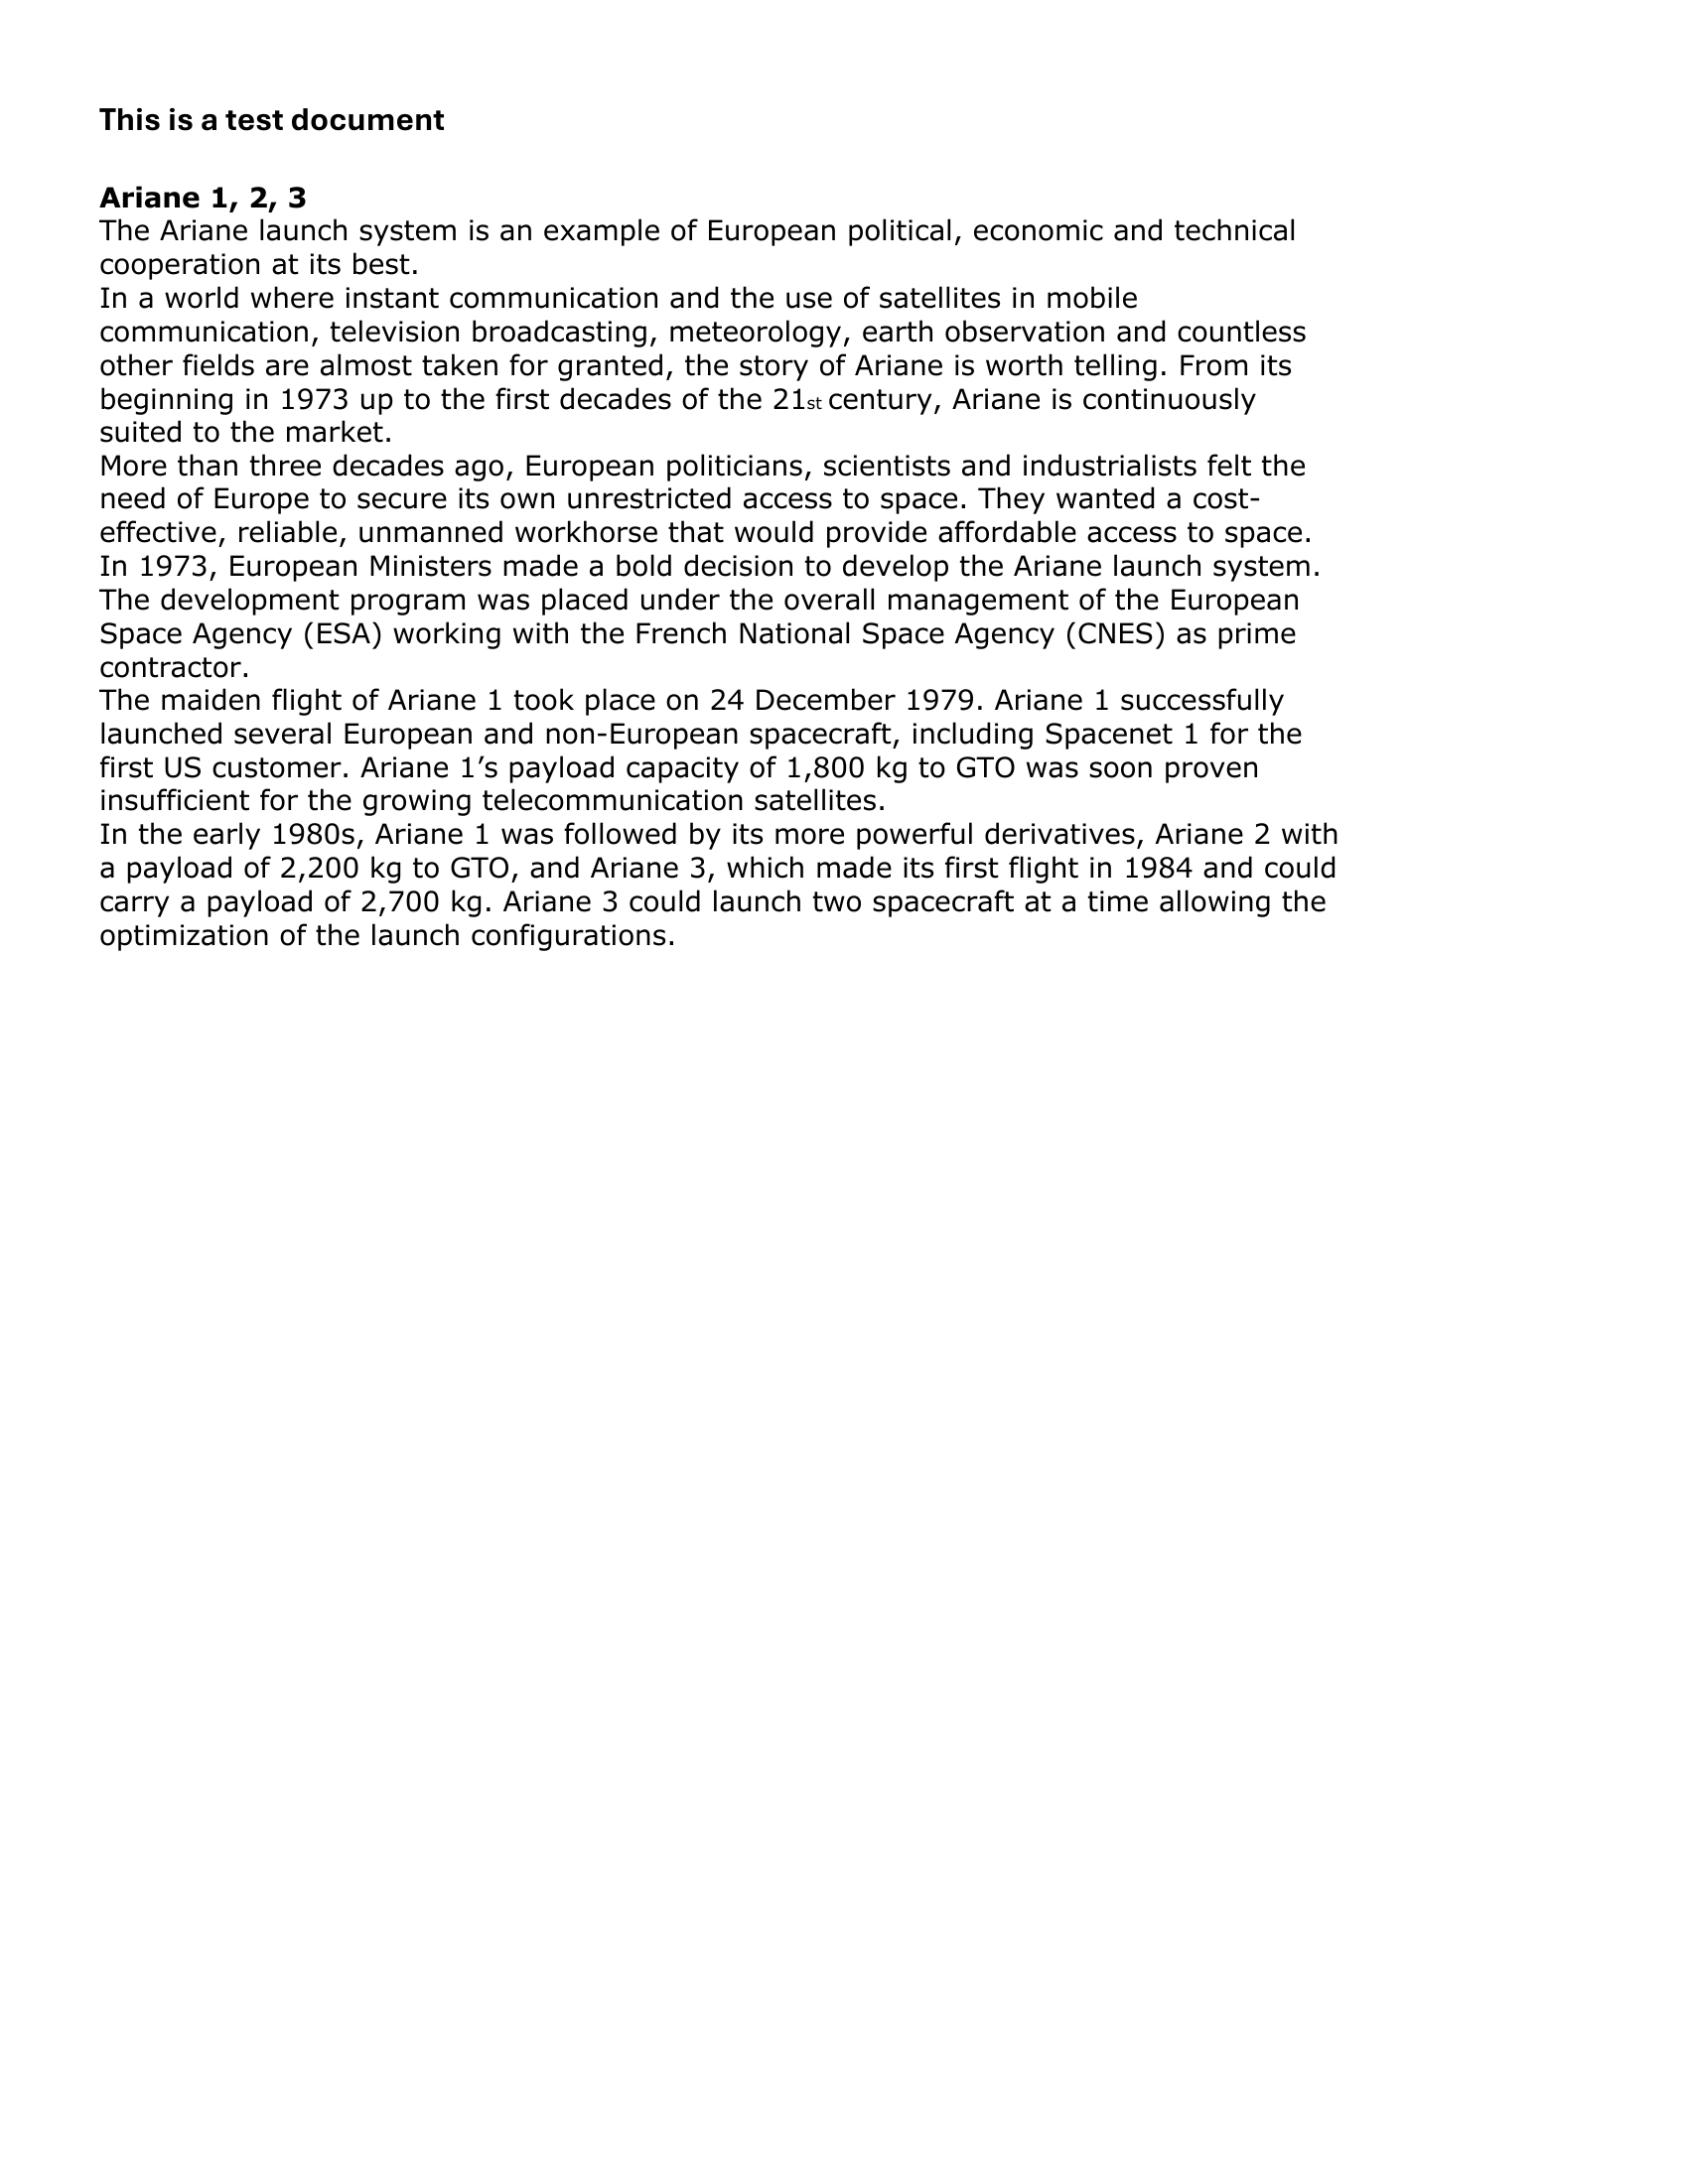

In [48]:
import sqlite3, pickle
import numpy as np


base = '/Users/e346104/git/DS/colpali-llama-vision-rag/'
conn = sqlite3.connect(f'{base}image_embeddings.db')

with torch.no_grad():
    batch_query = processor.process_queries([query]).to(model.device)
    query_embedding = model(**batch_query)
query_embedding_cpu = query_embedding.cpu().to(torch.float32).numpy()[0]

# Retrieve image embeddings from database
c = conn.cursor()
c.execute('SELECT image_base64, embedding FROM embeddings')
rows = c.fetchall()
conn.close()

assert rows, ("No images found in the index. Please add images first.")

# Set fixed sequence length
MAX_SEQ_LEN = 620  # Adjust based on your embeddings

image_embeddings_list = []
image_base64_list = []

for row in rows:
    image_base64, embedding_bytes = row
    embedding = pickle.loads(embedding_bytes)
    seq_len, embedding_dim = embedding.shape

    embedding_fixed = adjustSeq(MAX_SEQ_LEN, embedding)
    image_embeddings_list.append(embedding_fixed)
    image_base64_list.append(image_base64)

retrieved_image_embeddings = np.stack(image_embeddings_list)

# Adjust query embedding
seq_len_q, embedding_dim_q = query_embedding_cpu.shape
query_embedding_fixed = adjustSeq(MAX_SEQ_LEN, query_embedding_cpu)

# Convert to tensors
query_embedding_tensor = torch.from_numpy(query_embedding_fixed).to(model.device).unsqueeze(0)
retrieved_image_embeddings_tensor = torch.from_numpy(retrieved_image_embeddings).to(model.device)

# Compute similarity scores
with torch.no_grad():
    scores = processor.score_multi_vector(query_embedding_tensor, retrieved_image_embeddings_tensor)
scores_np = scores.cpu().numpy().flatten()
#del query_embedding_tensor, retrieved_image_embeddings_tensor, scores  # Free up memory

# Combine images and scores
similarities = list(zip(image_base64_list, scores_np))

# Sort by similarity
similarities.sort(key=lambda x: x[1], reverse=True)

if similarities:
    img_str, score = similarities[0]
    # Decode image from base64
    img_data = base64.b64decode(img_str)
    image = Image.open(io.BytesIO(img_data))
    print([s[1] for s in similarities])
    display(image)
else:
    print("OOOPA")

In [185]:
embeddings_tensor.shape, retrieved_image_embeddings_tensor.shape

(torch.Size([3, 620, 128]), torch.Size([323, 620, 128]))

In [171]:
import ollama, gc

stream = ollama.chat(
    model="llama3.2-vision",
    messages=[
        {
            'role': 'user',
            'content': "Please answer the following question using only the information visible in the provided image" 
            " Do not use any of your own knowledge, training data, or external sources."
            " Base your response solely on the content depicted within the image."
            " If there is no relation with question and image," 
            f" you can respond with 'Question is not related to image'.\nHere is the question: {query}",
            'images': [img_data]
        }
    ],
    stream=True
)
collected_chunks = []
stream_iter = iter(stream)

# Continue streaming the rest of the response
for chunk in stream_iter:
    chunk_content = chunk['message']['content']
    collected_chunks.append(chunk_content)
    complete_response = ''.join(collected_chunks)

#clear_cache()
gc.collect()

INFO:httpx 2024-12-26 20:12:42,804 _client.py:1038:_send_single_request: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


10151